In [30]:
import pandas as pd
import math
import opensim as osim
from datetime import datetime
from math import pi
import os, math
from pathlib import Path
import pymysql
import matplotlib.pyplot as plt

In [31]:

################################# VARIABLE SETUP ################################################
FILEPATH = Path('c:\\Users\\kenzo\\Documents\\SENIOR DESIGN\\MotionMend\\Hardware\\Experimental\\Simulation')
FILENAME_SUFFIX = datetime.today().strftime('%Y_%m_%d_%H_%M')
FILE_HEADER = '''DataType=Quaternion
endheader'''
STO_FILENAME = os.path.join(FILEPATH, 'data', f'data_{FILENAME_SUFFIX}.sto')

### SIMULATION FILE PATH VARIABLES ###
modelFileName = os.path.join(FILEPATH, 'models','Rajagopal_2015.osim')          # The path to an input model
outputCalibratedFileName = os.path.join(FILEPATH, 'models', 'calibrated_model.osim')
resultsDirectory = os.path.join(FILEPATH, 'IK_results')
MOT_FILENAME = os.path.join(resultsDirectory, f'ik_data_{FILENAME_SUFFIX}.mot')

### CALIBRATION VARIABLES ###
CALIBRATE = True
sensor_to_opensim_rotations = osim.Vec3(-pi/2, 0, 0)# The rotation of IMU data to the OpenSim world frame
baseIMUName = 'pelvis_imu'                     # The base IMU is the IMU on the base body of the model that dictates the heading (forward) direction of the model.
baseIMUHeading = '-z'                           # The Coordinate Axis of the base IMU that points in the heading direction. 
visulizeCalibration = False                     # Boolean to Visualize the Output model

### INVERSE KINEMATICS VARIABLES ###
sensor_to_opensim_rotation = osim.Vec3(-pi/2, 0, 0) # The rotation of IMU data to the OpenSim world frame
visualizeTracking = True  # Boolean to Visualize the tracking simulation
startTime = 0           # Start time (in seconds) of the tracking simulation. 
endTime = 1000              # End time (in seconds) of the tracking simulation.


In [32]:

def read_from_rds(host, port, database, user, password, query):
    try:
        connection = pymysql.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=database
        )

        print("Connected to RDS database")
        # Create a cursor object
        cursor = connection.cursor()

        # Execute a SQL query
        cursor.execute(query)

        # Fetch the results
        result = cursor.fetchall()

        column_names = [desc[0] for desc in cursor.description]

        # Convert the result to a pandas DataFrame
        df = pd.DataFrame(result, columns=column_names)
        return df

    finally:
        cursor.close()
        connection.close()
        print("MySQL connection is closed")


In [33]:
# Function to convert Roll, Pitch, Yaw to Quaternion
def rpy_to_quaternion(roll, pitch, yaw):
    # Convert angles to radians
    roll = math.radians(roll)
    pitch = math.radians(pitch)
    yaw = math.radians(yaw)

    # Quaternion conversion
    q_w = math.cos(roll/2) * math.cos(pitch/2) * math.cos(yaw/2) + math.sin(roll/2) * math.sin(pitch/2) * math.sin(yaw/2)
    q_x = math.sin(roll/2) * math.cos(pitch/2) * math.cos(yaw/2) - math.cos(roll/2) * math.sin(pitch/2) * math.sin(yaw/2)
    q_y = math.cos(roll/2) * math.sin(pitch/2) * math.cos(yaw/2) + math.sin(roll/2) * math.cos(pitch/2) * math.sin(yaw/2)
    q_z = math.cos(roll/2) * math.cos(pitch/2) * math.sin(yaw/2) - math.sin(roll/2) * math.sin(pitch/2) * math.cos(yaw/2)

    return f'{q_w:.6f},{q_x:.6f},{q_y:.6f},{q_z:.6f}'

def process_row(row):
    """
    Process a row of the pandas DataFrame.

    Parameters:
        row (pd.Series): A row of the DataFrame.

    Returns:
        pd.Series: A processed Series with updated columns.
    """
    # Rename 'timestamp' to 'time'
    row.rename({'timestamp': 'time'}, inplace=True)

    # Apply the rpy_to_quaternion function and create new columns
    row['pelvis_imu'] = rpy_to_quaternion(row['pelvis_roll'], row['pelvis_pitch'], row['pelvis_yaw'])
    row['femur_r_imu'] = rpy_to_quaternion(row['femur_r_roll'], row['femur_r_pitch'], row['femur_r_yaw'])
    row['tibia_r_imu'] = rpy_to_quaternion(row['tibia_r_roll'], row['tibia_r_pitch'], row['tibia_r_yaw'])

    # Drop roll, pitch, and yaw columns
    row.drop(['pelvis_roll', 'pelvis_pitch', 'pelvis_yaw',
              'femur_l_roll', 'femur_l_pitch', 'femur_l_yaw',
              'tibia_l_roll', 'tibia_l_pitch', 'tibia_l_yaw',
              'femur_r_roll', 'femur_r_pitch', 'femur_r_yaw',
              'tibia_r_roll', 'tibia_r_pitch', 'tibia_r_yaw'], inplace=True)

    return row

def add_header(filename, header):
    try:
        with open(filename, 'r') as file:
            original_contents = file.read()

        with open(filename, 'w') as file:
            file.write(header + original_contents)

    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

Name: senior-design-db
User: peterismostpro
Pass: p3tah!theStall1on


Endpoint/Host:
senior-design-db.cpkioi4c2tfg.us-east-1.rds.amazonaws.com

Port:
3306


In [34]:
host = 'senior-design-db.cpkioi4c2tfg.us-east-1.rds.amazonaws.com'
user = 'peterismostpro'
password = 'p3tah!theStall1on'
database = 'MOTION_MEND'
port = 3306

In [35]:

# Example usage
query = """
    SELECT * FROM patient_data
    WHERE patient_id = (
        SELECT MAX(patient_id)
        FROM patient_data
    )
    ORDER BY timestamp ASC
        """

data = read_from_rds(host, port, database, user, password, query)
# data = pd.DataFrame(patient_data_df)

data.head()

Connected to RDS database
MySQL connection is closed


,patient_id,timestamp,pelvis_roll,pelvis_pitch,pelvis_yaw,femur_l_roll,femur_l_pitch,femur_l_yaw,femur_r_roll,femur_r_pitch,femur_r_yaw,tibia_l_roll,tibia_l_pitch,tibia_l_yaw,tibia_r_roll,tibia_r_pitch,tibia_r_yaw,knee_angle_l,knee_angle_r
0,1,2024-12-14 01:26:56.194108,7.40,-68.92,0.0,92.46,2.22,0.0,89.89,0.82,0.0,89.89,0.82,0.0,92.46,2.22,0.0,-0.0784,-0.0784
1,1,2024-12-14 01:26:56.194111,7.41,-68.90,0.0,92.44,2.21,0.0,89.89,0.75,0.0,89.89,0.75,0.0,92.44,2.21,0.0,-0.0784,-0.0784
2,1,2024-12-14 01:26:56.194114,7.41,-68.87,0.0,92.51,2.17,0.0,89.91,0.76,0.0,89.91,0.76,0.0,92.51,2.17,0.0,-0.0084,-0.0084
3,1,2024-12-14 01:26:56.311865,7.35,-68.89,0.0,92.54,2.11,0.0,89.94,0.76,0.0,89.94,0.76,0.0,92.54,2.11,0.0,-0.1084,-0.1084
4,1,2024-12-14 01:26:56.311868,7.33,-68.89,0.0,92.52,2.01,0.0,89.94,0.70,0.0,89.94,0.70,0.0,92.52,2.01,0.0,-0.0684,-0.0684


In [36]:
len(data)

950

In [37]:
data.tail()

,patient_id,timestamp,pelvis_roll,pelvis_pitch,pelvis_yaw,femur_l_roll,femur_l_pitch,femur_l_yaw,femur_r_roll,femur_r_pitch,femur_r_yaw,tibia_l_roll,tibia_l_pitch,tibia_l_yaw,tibia_r_roll,tibia_r_pitch,tibia_r_yaw,knee_angle_l,knee_angle_r
945,1,2024-12-14 01:27:27.634343,-157.09,-84.78,0.0,75.70,-79.53,0.0,104.88,-39.89,0.0,104.88,-39.89,0.0,75.70,-79.53,0.0,80.0216,80.0216
946,1,2024-12-14 01:27:27.634347,-159.41,-84.36,0.0,75.63,-79.88,0.0,105.64,-42.34,0.0,105.64,-42.34,0.0,75.63,-79.88,0.0,79.8716,79.8716
947,1,2024-12-14 01:27:27.634349,-161.04,-83.98,0.0,74.65,-80.15,0.0,106.39,-44.81,0.0,106.39,-44.81,0.0,74.65,-80.15,0.0,79.7816,79.7816
948,1,2024-12-14 01:27:27.694550,-163.21,-83.57,0.0,73.46,-80.41,0.0,107.40,-47.22,0.0,107.40,-47.22,0.0,73.46,-80.41,0.0,79.6716,79.6716
949,1,2024-12-14 01:27:27.694553,-164.96,-83.14,0.0,72.75,-80.82,0.0,108.11,-49.67,0.0,108.11,-49.67,0.0,72.75,-80.82,0.0,79.5216,79.5216


In [38]:

quaternions = data.apply(process_row, axis=1)
quaternions = quaternions[['time', 'pelvis_imu', 'femur_r_imu', 'tibia_r_imu']]
quaternions['time'] = (quaternions['time'] - quaternions['time'].iloc[0]).dt.total_seconds()
quaternions['femur_l_imu'] = quaternions['femur_r_imu'].iloc[0]
quaternions['tibia_l_imu'] = quaternions['tibia_r_imu'].iloc[0]
quaternions.head()

,time,pelvis_imu,femur_r_imu,tibia_r_imu,femur_l_imu,tibia_l_imu
0,0.000000,"0.822803,0.053208,-0.564651,0.036514","0.707767,0.706410,0.005065,-0.005055","0.691635,0.721987,0.013401,-0.013989","0.707767,0.706410,0.005065,-0.005055","0.691635,0.721987,0.013401,-0.013989"
1,0.000003,"0.822897,0.053286,-0.564505,0.036554","0.707770,0.706413,0.004632,-0.004624","0.691763,0.721868,0.013343,-0.013924","0.707767,0.706410,0.005065,-0.005055","0.691635,0.721987,0.013401,-0.013989"
2,0.000006,"0.823044,0.053296,-0.564289,0.036540","0.707646,0.706536,0.004693,-0.004686","0.691326,0.722295,0.013093,-0.013680","0.707767,0.706410,0.005065,-0.005055","0.691635,0.721987,0.013401,-0.013989"
3,0.117757,"0.822974,0.052859,-0.564452,0.036254","0.707461,0.706721,0.004692,-0.004687","0.691144,0.722483,0.012728,-0.013305","0.707767,0.706410,0.005065,-0.005055","0.691635,0.721987,0.013401,-0.013989"
4,0.117760,"0.822983,0.052715,-0.564458,0.036156","0.707464,0.706723,0.004322,-0.004317","0.691281,0.722374,0.012127,-0.012672","0.707767,0.706410,0.005065,-0.005055","0.691635,0.721987,0.013401,-0.013989"


In [39]:
quaternions.to_csv(STO_FILENAME, index=False, sep='\t')
add_header(STO_FILENAME, FILE_HEADER + '\n')

In [40]:
if CALIBRATE and False:
    # Instantiate an IMUPlacer object
    imuPlacer = osim.IMUPlacer()

    # Set properties for the IMUPlacer
    imuPlacer.set_model_file(modelFileName)
    imuPlacer.set_orientation_file_for_calibration(STO_FILENAME)
    imuPlacer.set_sensor_to_opensim_rotations(sensor_to_opensim_rotations)
    imuPlacer.set_base_imu_label(baseIMUName)
    imuPlacer.set_base_heading_axis(baseIMUHeading)

    # Run the IMUPlacer
    imuPlacer.run(visulizeCalibration)

    # Get the model with the calibrated IMU
    model = imuPlacer.getCalibratedModel()

    # Print the calibrated model to file.
    model.printToXML(outputCalibratedFileName)

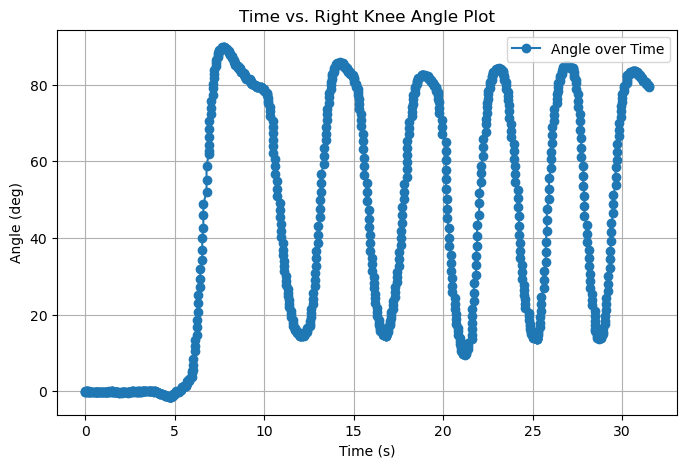

In [41]:
# Separate the tuples into two lists: time and value
time, value = quaternions['time'], data['knee_angle_l']

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(time, value, marker='o', linestyle='-', label='Angle over Time')

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Time vs. Right Knee Angle Plot')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [42]:
STO_FILENAME2 = 'c:\\Users\\kenzo\\Documents\\SENIOR DESIGN\\MotionMend\\Hardware\\Experimental\\Simulation\\data\\data_2024_12_05_17_24.sto'

In [45]:
# Instantiate an InverseKinematicsTool
imuIK = osim.IMUInverseKinematicsTool()
 
# Set tool properties
imuIK.set_model_file(outputCalibratedFileName)
imuIK.set_orientations_file(STO_FILENAME2)
imuIK.set_sensor_to_opensim_rotations(sensor_to_opensim_rotation)
imuIK.set_results_directory(resultsDirectory)

# Set time range in seconds
imuIK.set_time_range(0, startTime) 
imuIK.set_time_range(1, endTime)   

# Run IK
imuIK.run(visualizeTracking)

True